In [44]:
import numpy as np
import matplotlib.pyplot as plt
from galton_utils import create_combined_plot, simulate_multiple_beads
%matplotlib inline

# Galton Board Simulation Utilities Documentation

This module contains utilities for simulating and visualizing a Galton Board with memory effect on a rocking ship.

## Simulation Functions

### `simulate_single_bead(alpha, s, n_rows=31)`
Simulates the path of a single bead through the Galton board.
- **Parameters:**
  - `alpha`: Memory effect parameter [0, 0.5]
  - `s`: Ship tilt parameter [-0.25, 0.25]
  - `n_rows`: Number of rows in the board (default: 31)
- **Returns:** Final position of the bead (0 to n_rows)

### `simulate_multiple_beads(n_beads, alpha, s, n_rows=31)`
Simulates multiple beads through the Galton board.
- **Parameters:**
  - `n_beads`: Number of beads to simulate
  - `alpha`: Memory effect parameter [0, 0.5]
  - `s`: Ship tilt parameter [-0.25, 0.25]
  - `n_rows`: Number of rows in the board (default: 31)
- **Returns:** Array with the count of beads in each final position

## Visualization Functions

### `plot_galton_board(ax)`
Creates a stylized visualization of the Galton board structure.
- **Parameters:**
  - `ax`: Matplotlib axes object to plot on

### `plot_bead_distribution(positions, counts, ax)`
Plots the distribution of beads as a bar chart.
- **Parameters:**
  - `positions`: Array of x-positions (typically 0 to 31)
  - `counts`: Array of bead counts at each position
  - `ax`: Matplotlib axes object to plot on

### `create_combined_plot(counts, title=None)`
Creates a combined visualization with both the Galton board and bead distribution.
- **Parameters:**
  - `counts`: Array of bead counts at each position
  - `title`: Optional title for the plot
- **Returns:** Tuple of (figure, (ax1, ax2))

### `plot_distribution_only(counts, title=None)`
Creates a single plot showing just the bead distribution.
- **Parameters:**
  - `counts`: Array of bead counts at each position
  - `title`: Optional title for the plot
- **Returns:** Tuple of (figure, ax)

## Usage Example:
```python
# Run simulation
results = simulate_multiple_beads(n_beads=1000, alpha=0.2, s=0.1)

# Create visualization
fig, axes = create_combined_plot(
    results, 
    'Galton Board Simulation'
)
plt.show()

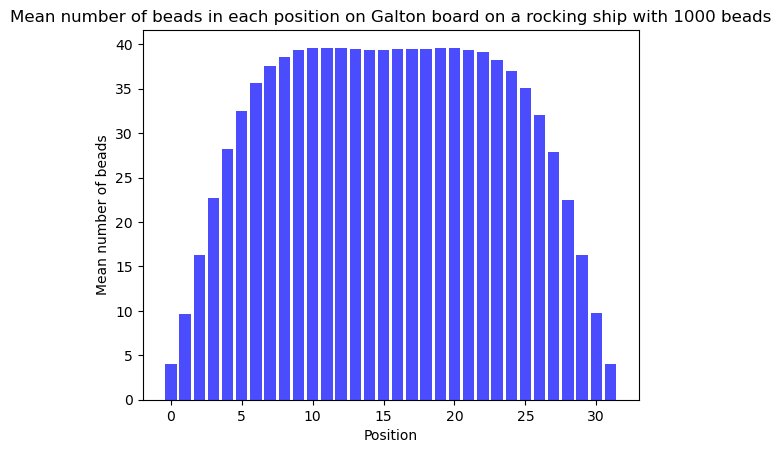

In [45]:
data = np.load('board_data_.npy')

#plot mean of rows in bar chart
mean_data = np.mean(data, axis=0)
plt.bar(np.arange(len(mean_data)), mean_data, color = 'blue', alpha = 0.7)
plt.xlabel('Position')
plt.ylabel('Mean number of beads')
plt.title('Mean number of beads in each position on Galton board on a rocking ship with 1000 beads')
plt.show()

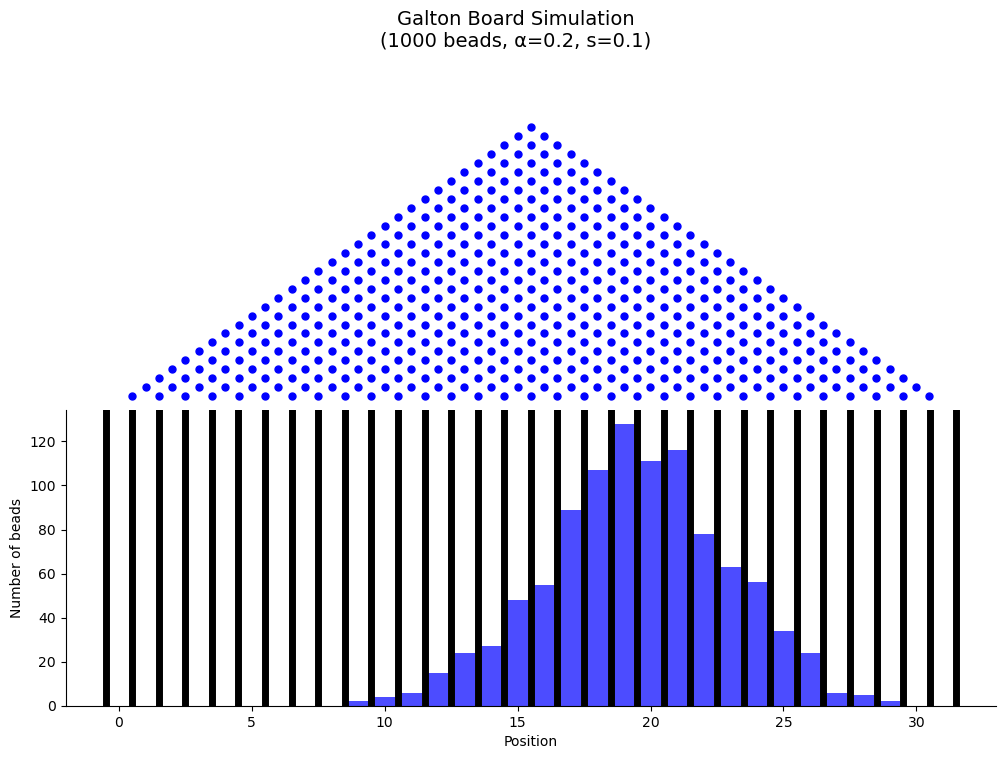

Total beads: 1000
Mean position: 19.46


In [46]:
# Test parameters
n_beads = 1000
alpha_test = 0.2
s_test = 0.1

# Run simulation
results = simulate_multiple_beads(n_beads, alpha_test, s_test)

# Create combined plot
fig, axes = create_combined_plot(
    results, 
    f'Galton Board Simulation\n({n_beads} beads, α={alpha_test}, s={s_test})'
)
plt.show()

# Print some statistics
print(f"Total beads: {np.sum(results)}")
print(f"Mean position: {np.average(range(len(results)), weights=results):.2f}")

# TASK 1

In [47]:
# Parameters
s_values =np.linspace(-0.25, 0.25, 100)
alpha_values = np.linspace(0, 0.5, 100)
n_beads = 1000

visualization_condition = False

if visualization_condition == True:
    # Simulate and visualize for each combination of alpha and s
    for alpha in alpha_values:
        for s in s_values:
             results = simulate_multiple_beads(n_beads, alpha, s)
             
             # Plot the results
             fig, axes = create_combined_plot(
                results, 
                f'Galton Board Simulation\n(n_beads={n_beads}, α={alpha}, s={s})'
                )
             plt.show()

In [48]:
simulation_data = {}

for alpha in alpha_values:
    for s in s_values:
        results = simulate_multiple_beads(n_beads, alpha, s)
        simulation_data[(alpha, s)] = results

# Access data for alpha_0, s_0
example_results = simulation_data[(alpha_values[0], s_values[0])]
print(f"Bead counts for α={alpha_values[0]}, s={s_values[0]}: {example_results}")


Bead counts for α=0.0, s=-0.25: [  0   0   8  27  48 106 134 160 152 137  91  63  39  16  11   8   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


# TASK 2

In [49]:
def compute_summary_statistic(bead_distribution):
    """
    Computes the mean position of the beads as a summary statistic.
    """
    positions = np.arange(len(bead_distribution))
    mean_position = np.average(positions, weights=bead_distribution)
    return mean_position

def estimate_kernel_size(simulated_data, observed_stat):
    """
    Estimates a reasonable kernel size based on deviations from the observed statistic.
    """
    deviations = [abs(sim_stat - observed_stat) for sim_stat in simulated_data]
    kernel_size = np.percentile(deviations, 25)  # 25th percentile
    return kernel_size


In [50]:
import random

def abc_routine(observed_distribution, n_samples, n_beads, n_rows=31):
    """
    Approximate Bayesian Computation (ABC) routine.
    
    Parameters:
        observed_distribution (array): Observed bead distribution.
        n_samples (int): Number of accepted samples to generate.
        n_beads (int): Number of beads in each simulation.
        n_rows (int): Number of rows in the Galton board.
    
    Returns:
        list: Accepted samples (alpha, s).
    """
    observed_stat = compute_summary_statistic(observed_distribution)
    accepted_samples = [] # A list to store accepted (alpha, s) that pass the kernel threshold
    simulated_stats = [] # A list to collect initial summary statistics from random simulations
    
    # Estimate kernel size using prior simulations
    for _ in range(100):  # Run initial simulations to estimate kernel
        alpha = random.uniform(0, 0.5) # Uniform prior for alpha
        s = random.uniform(-0.25, 0.25) # Uniform prior for s
        sim_distribution = simulate_multiple_beads(n_beads, alpha, s, n_rows)
        simulated_stats.append(compute_summary_statistic(sim_distribution))
    
    kernel_size = estimate_kernel_size(simulated_stats, observed_stat)
    print(f"Estimated Kernel Size: {kernel_size}")
    
    # ABC Sampling
    while len(accepted_samples) < n_samples:
        alpha = random.uniform(0, 0.5)
        s = random.uniform(-0.25, 0.25)
        
        sim_distribution = simulate_multiple_beads(n_beads, alpha, s, n_rows)
        sim_stat = compute_summary_statistic(sim_distribution)
        
        if abs(sim_stat - observed_stat) <= kernel_size:
            accepted_samples.append((alpha, s))
    
    return accepted_samples


In [51]:
# Example Observed Data 
observed_distribution = np.load('board_data_.npy')[0]  # Example: First experiment data

# Parameters
n_samples = 100
n_beads = 1000

# Run ABC
accepted_samples = abc_routine(observed_distribution, n_samples, n_beads)

# Output Results
for alpha, s in accepted_samples[:10]:  # Print first 10 accepted samples
    print(f"Accepted Sample - Alpha: {alpha}, S: {s}")


Estimated Kernel Size: 3.2597500000000004
Accepted Sample - Alpha: 0.4787382848701003, S: -0.07055408277522301
Accepted Sample - Alpha: 0.21741813112448022, S: -0.1514170549037432
Accepted Sample - Alpha: 0.427261597229439, S: -0.19058124329466625
Accepted Sample - Alpha: 0.08463957391071103, S: -0.16950856229260836
Accepted Sample - Alpha: 0.35882350735122026, S: -0.1769253364241976
Accepted Sample - Alpha: 0.12852207080762207, S: -0.17824821521883455
Accepted Sample - Alpha: 0.17720453928773422, S: -0.22900579253838
Accepted Sample - Alpha: 0.09179042647920621, S: -0.16965603368848126
Accepted Sample - Alpha: 0.45667709532632855, S: -0.15953694584475264
Accepted Sample - Alpha: 0.04179335213044538, S: -0.16306529762947258
